<div align="center">
  <img src="https://officenationalstatistics.sharepoint.com/:i:/r/sites/itoDSTPMO/DAPCATS/04.%20Technical/02.%20Development_Test/images_for_gitlab/dap-cats-ds-logo.png"/></div>
  
# Interpolation in PySpark

In this tip we will impute some missing values in time series data. This tip has been adapted from [another source](https://walkenho.github.io/interpolating-time-series-p2-spark/). 

Please note that there are many imputation methods to choose from, for more information see the [Awareness in Editing and Imputation](https://learninghub.ons.gov.uk/enrol/index.php?id=574) course on the Learning Hub. Before using this code in your work please consult other team members or methodologists on the suitablility of this method for your use case. This code also hasn't been thoroughly tested, so please test it yourself before considering using it for production.

We don't want to spend too much time on the methodology here, the purpose is to give you inspiration on how to solve your own PySpark problem and maybe learn about some new functions.

It's also worth mentioning that there is an [interpolate function in pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html), so if your DataFrame is small enough just use pandas!


## What is interpolation?

[Wikipedia says](https://en.wikipedia.org/wiki/Interpolation) "In the mathematical field of numerical analysis, interpolation is a type of estimation, a method of constructing new data points based on the range of a discrete set of known data points."

The DataFrame we will create consists of the columns `area_code`, `period` and `count`. To impute the missing `count` values we will use linear interpolation, which means to draw a straight line between two known points and use this gradient line to fill in the missing values. 

The linear interpolation equation we will use is,

<span style=\"font-size:18px\">&#x1D49A; = &#x1D49A;<sub>&#x31;</sub> + &#x1D48E; (&#x1D499; &minus; &#x1D499;<sub>&#x31;</sub>)</span>

where

    m = (y2 - y1) / (x2 - x1)

is the gradient between points 1 and 2

y = linear interpolation value (`count` in this example), between y1 and y2

x = independant variable (`period` in this example), between x1 and x2

x1, y1 = known values at point 1

x2, y2 = known values at point 2

## Create DataFrame and plot

Let's start with some imports and creating a spark session 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import datetime

spark = (
    SparkSession.builder.appName("interpolate-tip")
    .getOrCreate()
)

As mentioned previously we will create three columns, `area_code`, `period` and `count`. Note that `count` contains some missing values to impute and `period` contains some mixed frequency points to make it more interesting.

In [2]:
df = spark.createDataFrame([
    ["A", "20210101", 100],
    ["A", "20210106", None],
    ["A", "20210111", None],
    ["A", "20210116", 130],
    ["A", "20210121", 100],
    ["A", "20210126", 120],
    ["A", "20210131", None],
    ["A", "20210205", 130],
    ["B", "20210101", None],
    ["B", "20210111", 85],
    ["B", "20210119", 82],
    ["B", "20210131", 75],
    ["B", "20210210", None],
    ["B", "20210215", 85],
    ["B", "20210220", None],
    ["B", "20210225", 75]
    ],
    ["area_code", "period", "count"])

Let's take a quick look at some charts to see what this looks like

In [3]:
import pandas as pd
pdf = df.toPandas()
pdf.set_index(pd.to_datetime(pdf["period"]), inplace=True)

In [4]:
pdf[pdf["area_code"]=="A"].plot(marker="o")
pdf[pdf["area_code"]=="B"].plot(marker="o")

As you can see, the lines don't meet all the points becuase there are missing counts in between.

## Interpolate

The approach we will take to interpolate is to create new columns containing forward filled and backward filled counts and periods where the `count` is missing. Then use these columns in the formula above to calculate the gradient and interpolated counts.

Here are the steps in more detail,
1. Add timestamp columns
2. Create ordered windows for forward and backward filling
3. Carry out the forward and backward fills on count and timestamp
4. Calculate the gradient
5. Calculate the interpolated counts

In practice there is often some cleaning to do with dates, here we just have a string in the format `YYYYMMDD`.

Before we impute any values we will create a flag to indicate an imputed value for the end user.

In [5]:
df = df.withColumn("impute_flag",
                   F.when(F.col("count").isNull(), 1)
                   .otherwise(0))

Next we will need to create some new timestamp columns. The function `unix_timestamp()` will convert the `period` column into [seconds since 1st of January 1970](https://en.wikipedia.org/wiki/Unix_time#:~:text=The%20Unix%20epoch%20is%20the,%2D01T00%3A00%3A00Z.). We need one version of the column with missing timestamps corresponding to the missing counts, and another version including all the periods.

In [6]:
# Add timestamp for data we have only. This will be used to interpolate
df = df.withColumn("timestamp_with_nulls",
                   F.when(F.col("impute_flag")!=1,
                          F.unix_timestamp(F.col("period"), "yyyyMMdd"))
                   .otherwise(None))

# Add timestamp for all data
df = df.withColumn("timestamp_all",
                  F.unix_timestamp(F.col("period"), "yyyyMMdd")
                  )

Next we create the `Window` functions to forward fill and backward fill the missing values in the `count` and `timestamp_with_nulls` columns.

In [7]:
# Create window for forward filling
window_ff = (
    Window
    .partitionBy("area_code")
    .orderBy("period")
    .rangeBetween(Window.unboundedPreceding, 0)
) 

# Create window for backward filling
window_bf = (
    Window
    .partitionBy('area_code')
    .orderBy("period")
    .rangeBetween(0, Window.unboundedFollowing)
) 

To forward and backward fill the missing values we use the `F.last()` and `F.first()` functions respectively. These will grab the preceding and following values of a missing value within our defined windows.

Once assembled we can put them in `.withColumn()` to add the forward and backward fill columns.

In [8]:
# create the series containing the filled values
count_last = F.last(F.col("count"), ignorenulls=True).over(window_ff)
count_first = F.first(F.col("count"), ignorenulls=True).over(window_bf)

period_last = F.last(F.col("timestamp_with_nulls"), ignorenulls=True).over(window_ff)
period_first = F.first(F.col("timestamp_with_nulls"), ignorenulls=True).over(window_bf)

# add the columns to the dataframe
df = (
    df.withColumn('count_ff', count_last)
    .withColumn('count_bf', count_first)
    .withColumn('period_ff', period_last)
    .withColumn('period_bf', period_first)
)

df.show()

+---------+--------+-----+-----------+--------------------+-------------+--------+--------+----------+----------+
|area_code|  period|count|impute_flag|timestamp_with_nulls|timestamp_all|count_ff|count_bf| period_ff| period_bf|
+---------+--------+-----+-----------+--------------------+-------------+--------+--------+----------+----------+
|        B|20210101| null|          1|                null|   1609459200|    null|      85|      null|1610323200|
|        B|20210111|   85|          0|          1610323200|   1610323200|      85|      85|1610323200|1610323200|
|        B|20210119|   82|          0|          1611014400|   1611014400|      82|      82|1611014400|1611014400|
|        B|20210131|   75|          0|          1612051200|   1612051200|      75|      75|1612051200|1612051200|
|        B|20210210| null|          1|                null|   1612915200|      75|      85|1612051200|1613347200|
|        B|20210215|   85|          0|          1613347200|   1613347200|      85|      

We're now ready to calculate the gradient between the known points and interpolate. 

In [9]:
# Create a gradient column
df = df.withColumn("gradient",
                   F.when(F.col("impute_flag")==1,
                          (F.col("count_bf") - F.col("count_ff")) /
                          (F.col("period_bf") - F.col("period_ff")))
                   .otherwise(0)
                  )

# Create the imputed values
df = df.withColumn("count_final",
                  F.when(F.col("impute_flag")==1,
                        F.col("count_ff") +
                        F.col("gradient") *
                        (F.col("timestamp_all") - F.col("period_ff"))
                        )
                   .otherwise(F.col("count"))
                  )

## View the results

To view the results we will select the columns of interest and convert to pandas.

In [10]:
pdf = df.select("area_code", "period", "count", "impute_flag", "count_final").toPandas()
pdf = pdf.set_index(pd.to_datetime(pdf["period"])).drop("period", axis=1)
pdf

,area_code,count,impute_flag,count_final
period,,,,
2021-01-01,B,NaN,1,NaN
2021-01-11,B,85.0,0,85.000000
2021-01-19,B,82.0,0,82.000000
2021-01-31,B,75.0,0,75.000000
2021-02-10,B,NaN,1,81.666667
2021-02-15,B,85.0,0,85.000000
2021-02-20,B,NaN,1,80.000000
2021-02-25,B,75.0,0,75.000000
2021-01-01,A,100.0,0,100.000000


Note that the first value for `area_code` B could not be interpolated because there is no preceding count available. In other words, we would need to extrapolate to estimate for this value.

Once again, we will plot the series with pandas. The original data are plotted as red circles and the final series in blue.

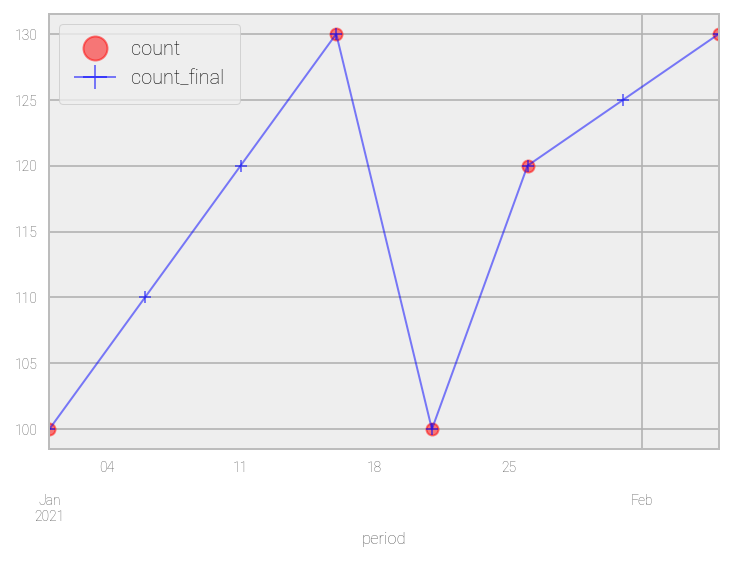

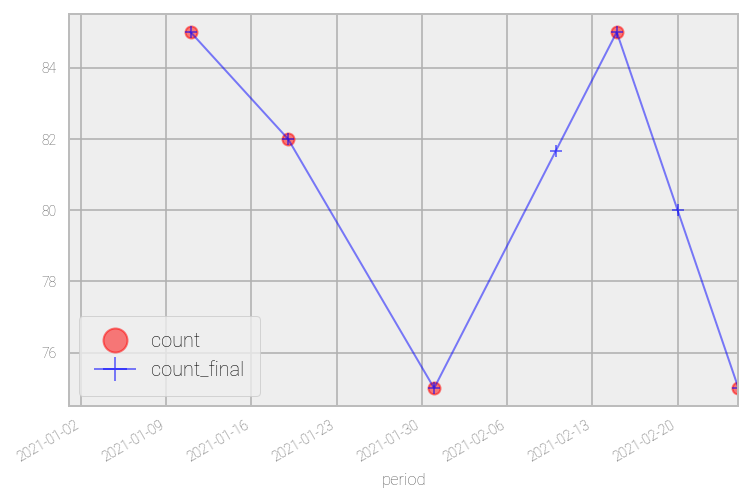

In [11]:
pdf[pdf["area_code"] == "A"].drop("impute_flag", axis=1).plot(style={"count":"ro", "count_final":"b+-"}, alpha=0.5)
pdf[pdf["area_code"] == "B"].drop("impute_flag", axis=1).plot(style={"count":"ro", "count_final":"b+-"}, alpha=0.5)

## Further resources

- This tip has been adapted from [another source](https://walkenho.github.io/interpolating-time-series-p2-spark/). Note that the method shown in the linked page uses User Defined Functions (UDFs).
- For more information about imputation, see the [Awareness in Editing and Imputation](https://learninghub.ons.gov.uk/enrol/index.php?id=574) course on the Learning Hub.
- If your DataFrame is small enough [just use pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html).
- Wikipedia definition for [interpolation](https://en.wikipedia.org/wiki/Interpolation)